In [20]:
import itertools
import random
from collections import defaultdict
from typing import Callable, Optional, Tuple, Union

import networkx as nx
import numpy as np
import torch
import torch.nn.functional as F
from networkx.algorithms.centrality import degree_centrality
from scipy.stats import entropy
from torch import Tensor
from torch.nn import Linear
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing, TopKPooling
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import from_networkx, to_networkx
from torch_scatter import scatter_mean

from custom.args import grey, purple
from custom.dataset import GraphDataset, create_dataset
from custom.utils import *
from gmn import *

In [21]:
def pyg_to_nx(data):
    return to_networkx(data, to_undirected=True)


def nx_to_pyg(G):
    return from_networkx(G)


def mc_split(G1, G2):
    incumbent = []
    max_size = 0

    def search(mapping, future, incumbent):
        nonlocal max_size
        if len(mapping) > max_size:
            max_size = len(mapping)
            incumbent = mapping[:]
        bound = len(mapping) + sum(min(len(g), len(h)) for g, h in future)
        if bound <= max_size:
            return incumbent
        G, H = min(future, key=lambda x: max(len(x[0]), len(x[1])))
        v = max(G, key=lambda x: G1.degree[x])
        for w in H:
            future_prime = []
            for G_prime, H_prime in future:
                G_prime_adj = [u for u in G_prime if u != v and u in G1.neighbors(v)]
                H_prime_adj = [u for u in H_prime if u != w and u in G2.neighbors(w)]
                if G_prime_adj and H_prime_adj:
                    future_prime.append((G_prime_adj, H_prime_adj))
                G_prime_non_adj = [
                    u for u in G_prime if u != v and u not in G1.neighbors(v)
                ]
                H_prime_non_adj = [
                    u for u in H_prime if u != w and u not in G2.neighbors(w)
                ]
                if G_prime_non_adj and H_prime_non_adj:
                    future_prime.append((G_prime_non_adj, H_prime_non_adj))
            incumbent = search(mapping + [(v, w)], future_prime, incumbent)
        G_prime = [u for u in G if u != v]
        future.remove((G, H))
        if G_prime:
            future.append((G_prime, H))
        incumbent = search(mapping, future, incumbent)
        return incumbent

    future = [(list(G1.nodes), list(G2.nodes))]
    incumbent = search([], future, incumbent)

    return incumbent


def max_common_subgraph(data1, data2):
    G1 = pyg_to_nx(data1)
    G2 = pyg_to_nx(data2)
    mapping = mc_split(G1, G2)
    node_mapping = {v: w for v, w in mapping}
    return node_mapping


def most_isomorphic(a_pyg, b_pyg):
    a = [to_networkx(g, to_undirected=True) for g in a_pyg]
    b = [to_networkx(g, to_undirected=True) for g in b_pyg]
    isomorphism_counts = [0] * len(a)
    for i, g1 in enumerate(a):
        for g2 in b:
            if nx.is_isomorphic(g1, g2):
                isomorphism_counts[i] += 1
    max_index = isomorphism_counts.index(max(isomorphism_counts))
    return a_pyg[max_index]


def find_min_total_ged_graph(graphs):
    nx_graphs = [to_networkx(graph, to_undirected=True) for graph in graphs]

    total_geds = [0] * len(nx_graphs)

    for i, graph_i in enumerate(nx_graphs):
        for j, graph_j in enumerate(nx_graphs):
            if i != j:
                min_ged = float("inf")
                for ged_estimate in nx.optimize_graph_edit_distance(graph_i, graph_j):
                    min_ged = min(min_ged, ged_estimate)
                total_geds[i] += min_ged

    min_ged_index = total_geds.index(min(total_geds))

    return graphs[min_ged_index]


def remove_double_edges(edge_index):
    edge_list = edge_index.t()
    unique_edges = torch.unique(edge_list, dim=0)
    return unique_edges.t()


def combine_graphs(graph1, graph2, mapping, ratio=0.5):
    x1, edge_index1 = graph1.x, graph1.edge_index
    x2, edge_index2 = graph2.x, graph2.edge_index

    new_x_size = x1.size(0) + x2.size(0) - len(mapping)
    new_x = torch.zeros((new_x_size, x1.size(1)))

    new_index_map = {}
    current_index = 0

    for idx1, idx2 in mapping.items():
        new_x[current_index] = (x1[idx1] + x2[idx2]) * ratio
        new_index_map[idx1] = current_index
        new_index_map[x1.size(0) + idx2] = current_index
        current_index += 1

    for idx1 in range(x1.size(0)):
        if idx1 not in mapping:
            new_x[current_index] = x1[idx1]
            new_index_map[idx1] = current_index
            current_index += 1

    for idx2 in range(x2.size(0)):
        if idx2 not in mapping.values():
            new_x[current_index] = x2[idx2]
            new_index_map[x1.size(0) + idx2] = current_index
            current_index += 1

    new_edge_list = []
    for edge in edge_index1.t():
        new_edge_list.append(
            [new_index_map[edge[0].item()], new_index_map[edge[1].item()]]
        )
    offset = x1.size(0)
    for edge in edge_index2.t():
        new_edge_list.append(
            [
                new_index_map[offset + edge[0].item()],
                new_index_map[offset + edge[1].item()],
            ]
        )

    new_edge_index = torch.tensor(new_edge_list).t().contiguous()

    clean_edge_index = remove_double_edges(new_edge_index)

    combined_graph = Data(x=new_x, edge_index=clean_edge_index)

    return combined_graph


def find_most_common_graph(graphs, k, model):

    # k = min(k, len(graphs))

    def graph_hash(graph):
        G = to_networkx(graph, to_undirected=True)
        return tuple(sorted([d for n, d in G.degree()]))

    # hash_counts = defaultdict(int)
    # graph_by_hash = {}

    # for graph in graphs:
    #     hash_val = graph_hash(graph)
    #     hash_counts[hash_val] += 1
    #     if hash_val not in graph_by_hash:
    #         graph_by_hash[hash_val] = graph

    # most_common_hashes = sorted(hash_counts, key=hash_counts.get, reverse=True)[:k]
    # most_common_graphs = [graph_by_hash[hash_key] for hash_key in most_common_hashes]

    # if len(most_common_graphs) == 1:
    #     return most_common_graphs[0]

    # combined_clusters = []

    # for i in range(len(most_common_graphs)):
    #     for j in range(0, i):
    #         g1 = most_common_graphs[i]
    #         g2 = most_common_graphs[j]

    #         G1 = to_networkx(g1, to_undirected=True)
    #         G2 = to_networkx(g2, to_undirected=True)

    #         mcs = max_common_subgraph(g1, g2)

    #         combined_graph = combine_graphs(g1, g2, mcs)

    #         topk_pooling = TopKPooling(model.args.dim, ratio=8)
    #         combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = (
    #             topk_pooling(combined_graph.x, combined_graph.edge_index)
    #         )
    #         combined_clustered = Data(
    #             x=combined_clustered_x, edge_index=combined_clustered_edge_index
    #         )

    #         combined_clusters.append(combined_clustered)

    combined_hash_counts = defaultdict(int)
    combined_graph_by_hash = {}

    for graph in graphs:
        hash_val = graph_hash(graph)
        combined_hash_counts[hash_val] += 1
        if hash_val not in combined_graph_by_hash:
            combined_graph_by_hash[hash_val] = graph

    most_common_combined_hash = max(combined_hash_counts, key=combined_hash_counts.get)
    most_common_combined_graph = combined_graph_by_hash[most_common_combined_hash]

    return most_common_combined_graph


def calculate_weighted_confidence(scores, external_weights=None, w_avg=0.5, w_var=0.5):
    average_score = scores.mean()

    variance_score = scores.var()

    if variance_score == 0:
        inverse_variance = torch.tensor(0)
    else:
        inverse_variance = 1 / variance_score

    weighted_confidence = w_avg * average_score + w_var * inverse_variance

    if external_weights is not None:
        weighted_confidence += external_weights.sum() * 0.1

    return weighted_confidence.item()


# def select_cluster(model, k_threshold=0.8):
#     accs = []
#     cs = []
#     clustered_graphs = []

#     k = best_k(model, k_threshold)

#     # k = 8

#     best_acc1, best_acc2 = 0.0, 0.0
#     cluster1, cluster2 = None, None
#     layer1, layer2 = None, None

#     layers = []
#     sims = []

#     for i in range(len(model.layer_outputs)):
#         (x_1, edge_index_1, x_2, edge_index_2) = model.layer_outputs[i]

#         topk_pooling = TopKPooling(model.args.dim, ratio=8)

#         x_pooled_1, edge_index_pooled_1, _, _, perm1, score1 = topk_pooling(
#             x_1,
#             edge_index_1,
#         )
#         x_pooled_2, edge_index_pooled_2, _, _, perm2, score2 = topk_pooling(
#             x_2,
#             edge_index_2,
#         )

#         acc1 = len(set(range(8)) & set(perm1.tolist()))
#         acc2 = len(set(range(8)) & set(perm2.tolist()))

#         layers.append(
#             (
#                 (x_pooled_1, edge_index_pooled_1, score1),
#                 (x_pooled_2, edge_index_pooled_2, score2),
#                 i,
#             )
#         )

#         clustered_graphs.append(
#             (
#                 (
#                     Data(x=x_pooled_1, edge_index=edge_index_pooled_1),
#                     # abs(score1).sum().item(),
#                     calculate_weighted_confidence(score1),
#                 ),
#                 (
#                     Data(x=x_pooled_2, edge_index=edge_index_pooled_2),
#                     # abs(score2).sum().item(),
#                     calculate_weighted_confidence(score2),
#                 ),
#             )
#         )

#         if acc1 > best_acc1:
#             x = x_pooled_1
#             cluster1 = Data(x=x_pooled_1, edge_index=edge_index_pooled_1)
#             best_acc1 = acc1
#             layer1 = i + 1
#         if acc2 > best_acc2:
#             cluster2 = Data(x=x_pooled_2, edge_index=edge_index_pooled_2)
#             best_acc2 = acc2
#             layer2 = i + 1

#     cs.append((layers, layer1, layer2))

#     accs.append(best_acc1)
#     accs.append(best_acc2)

#     connected_1 = []
#     connected_2 = []
#     connected_pairs = []
#     all_clusters = []

#     for i in range(len(clustered_graphs)):
#         (g1, s1), (g2, s2) = clustered_graphs[i]
#         if nx.is_connected(to_networkx(g1, to_undirected=True)):
#             connected_1.append((g1, s1))
#         if nx.is_connected(to_networkx(g2, to_undirected=True)):
#             connected_2.append((g2, s2))

#         if nx.is_connected(to_networkx(g1, to_undirected=True)) and nx.is_connected(
#             to_networkx(g2, to_undirected=True)
#         ):
#             connected_pairs.append((g1, g2))
#         all_clusters.append((g1, s1))
#         all_clusters.append((g2, s2))

#     graphs = []

#     for i, (g1, s1) in enumerate(connected_1):
#         for j, (g2, s2) in enumerate(connected_2):
#             if nx.is_isomorphic(
#                 to_networkx(g1, to_undirected=True), to_networkx(g2, to_undirected=True)
#             ):
#                 graphs.append(
#                     (Data(x=(g1.x + g2.x) / 2, edge_index=g1.edge_index), i + 1, j + 1)
#                 )

#     # for graph in graphs:
#     # plot_graph(graph[0])

#     connected = connected_1 + connected_2
#     connected = sorted(connected, key=lambda x: x[1])

#     if graphs != []:
#         return (
#             find_most_common_graph([g[0] for g in graphs], 2, model),
#             k,
#             cluster1,
#             cluster2,
#             "isomorphic",
#             None,
#         )

#     elif connected != []:
#         connected_clustered = []
#         # for g1, s1 in connected_1:
#         #     for g2, s2 in connected_2:
#         #         # g1, g2 = connected_pairs[i]
#         #         G1 = to_networkx(g1, to_undirected=True)
#         #         G2 = to_networkx(g2, to_undirected=True)
#         #         ismags = nx.isomorphism.ISMAGS(G1, G2)
#         #         largest_common_subgraph = list(
#         #             ismags.largest_common_subgraph(symmetry=False)
#         #         )
#         #         # if nx.is_connected(G1) and nx.is_connected(G2):
#         #         combined_data = combine_graphs(
#         #             g1, g2, largest_common_subgraph[0], ratio=1
#         #         )

#         #         combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = (
#         #             topk_pooling(combined_data.x, combined_data.edge_index)
#         #         )

#         #         combined_clustered = Data(
#         #             x=combined_clustered_x, edge_index=combined_clustered_edge_index
#         #         )

#         #         # if nx.is_connected(to_networkx(combined_clustered, to_undirected=True)):
#         #         #     connected_clustered.append(combined_clustered)
#         #         if nx.is_isomorphic(
#         #             to_networkx(combined_clustered, to_undirected=True),
#         #             to_networkx(g1, to_undirected=True),
#         #         ) or nx.is_isomorphic(
#         #             to_networkx(combined_clustered, to_undirected=True),
#         #             to_networkx(g2, to_undirected=True),
#         #         ):
#         #             connected_clustered.append(combined_clustered)

#         return (
#             (
#                 find_most_common_graph(connected, 2, model)
#                 # random.choice(connected_clustered)
#                 if connected_clustered != []
#                 else find_most_common_graph([c[0] for c in connected], 2, model)
#             ),
#             k,
#             cluster1,
#             cluster2,
#             "connected_pair" if connected_clustered != [] else "connected",
#             connected_clustered,
#         )
#     elif connected_1 != [] or connected_2 != []:
#         return (
#             connected[0][0],
#             k,
#             cluster1,
#             cluster2,
#             "connected",
#             None,
#         )
#     else:
#         return (
#             random.choice(all_clusters)[0],
#             k,
#             cluster1,
#             cluster2,
#             "random",
#             None,
#         )

Total number of graphs: 360
Number of classes: 4
Number of node features: 4
Average number of nodes per graph: 18
Max number of nodes in a graph: 19
Min number of nodes in a graph: 17
Class distribution:
 - Class 1: 90 graphs (25.00%)
 - Class 0: 90 graphs (25.00%)
 - Class 2: 90 graphs (25.00%)
 - Class 3: 90 graphs (25.00%)


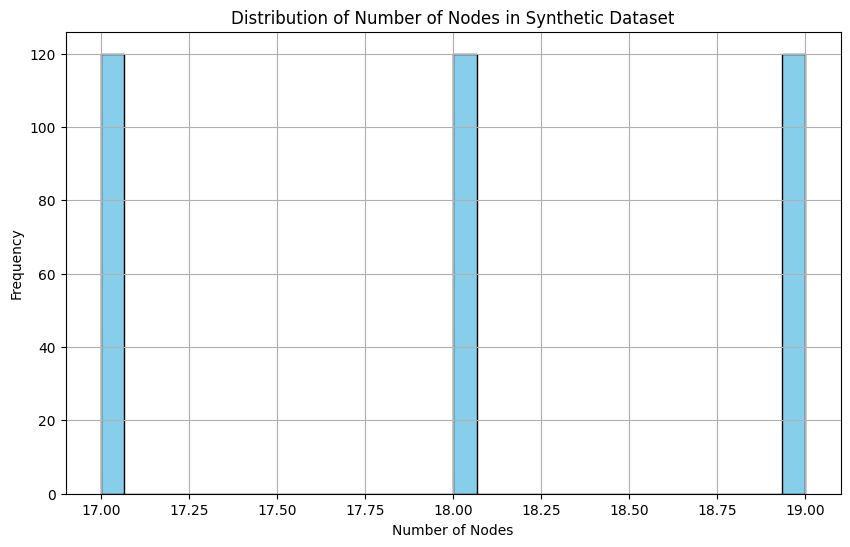

Small graphs: 360
Medium graphs: 0
Large graphs: 0


In [22]:
dataset = GraphDataset(torch.load("data/cycle_line_star_complete_1_15.pt"))

(
    small_graphs,
    medium_graphs,
    large_graphs,
    classes,
    small_classes,
    medium_classes,
    large_classes,
) = analyze_dataset(dataset)

In [23]:
def train(model, optimizer, pairs, labels, batch_size):
    model.train()
    train_losses = []
    train_accuracies = []
    losses = []
    accs = []

    def get_params(model):
        return {name: param.clone() for name, param in model.named_parameters()}

    initial_params = get_params(model)

    for i in range(len(pairs)):
        optimizer.zero_grad()

        graph1, graph2 = pairs[i]
        label = labels[i]

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([graph1.num_nodes])
        sizes_2 = torch.tensor([graph2.num_nodes])

        emb_1, emb_2, _, _, _, _ = model(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )

        metrics = model.compute_metrics(emb_1, emb_2, torch.tensor([label]))
        loss = metrics["loss"]
        acc = metrics["acc"]

        losses.append(loss)
        accs.append(acc)

        if i % batch_size == 0 and i > 0:
            batch_loss = torch.mean(torch.stack(losses))
            batch_acc = torch.mean(torch.stack(accs))
            losses = []
            accs = []
            train_losses.append(batch_loss.detach().numpy())
            train_accuracies.append(batch_acc.detach().numpy())
            batch_loss.backward()
            optimizer.step()
            # if i % 100 * batch_size == 0:
            #     print(
            #         f"Epoch: {i} - Loss: {batch_loss.item():.4f}, Acc: {batch_acc:.4f}"
            #     )

    trained_params = get_params(model)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [24]:
def best_k(model, threshold=0.8):
    def calculate_cumulative_scores(scores):
        normalized_scores = F.softmax(scores, dim=0)
        cumulative_scores = torch.cumsum(normalized_scores, dim=0)
        return cumulative_scores

    def find_best_k(cumulative_scores, total_percentage):
        k = ((cumulative_scores / cumulative_scores[-1]) >= total_percentage).nonzero()[
            0
        ].item() + 1
        return k

    layer_scores_1 = []
    layer_scores_2 = []
    for i in range(len(model.topk_outputs)):
        (
            (_, _, _, score1),
            (_, _, _, score2),
        ) = model.topk_outputs[i]
        layer_scores_1.append(score1)
        layer_scores_2.append(score2)

    k_values_graph1 = []
    for i, scores in enumerate(layer_scores_1):
        cumulative_scores = calculate_cumulative_scores(scores)
        best_k = find_best_k(cumulative_scores, threshold)
        k_values_graph1.append(best_k)

    k_values_graph2 = []
    for i, scores in enumerate(layer_scores_2):
        cumulative_scores = calculate_cumulative_scores(scores)
        best_k = find_best_k(cumulative_scores, threshold)
        k_values_graph2.append(best_k)

    combined_ks = k_values_graph1 + k_values_graph2

    return int(round(torch.mean(torch.tensor(combined_ks, dtype=float)).item()))

In [25]:
def best_k(model, threshold=0.8):
    def calculate_cumulative_scores(scores):
        normalized_scores = F.softmax(scores, dim=0)
        cumulative_scores = torch.cumsum(normalized_scores, dim=0)
        return cumulative_scores

    def find_best_k(cumulative_scores, total_percentage):
        k = ((cumulative_scores / cumulative_scores[-1]) >= total_percentage).nonzero()[
            0
        ].item() + 1
        return k

    layer_scores_1 = []
    layer_scores_2 = []
    for i in range(len(model.topk_outputs)):
        (
            (_, _, _, score1),
            (_, _, _, score2),
        ) = model.topk_outputs[i]
        layer_scores_1.append(score1)
        layer_scores_2.append(score2)

    k_values_graph1 = []
    for i, scores in enumerate(layer_scores_1):
        cumulative_scores = calculate_cumulative_scores(scores)
        best_k = find_best_k(cumulative_scores, threshold)
        k_values_graph1.append(best_k)

    k_values_graph2 = []
    for i, scores in enumerate(layer_scores_2):
        cumulative_scores = calculate_cumulative_scores(scores)
        best_k = find_best_k(cumulative_scores, threshold)
        k_values_graph2.append(best_k)

    combined_ks = k_values_graph1 + k_values_graph2

    return int(round(torch.mean(torch.tensor(combined_ks, dtype=float)).item()))

In [26]:
def select_cluster(model, k_threshold=0.8):
    accs = []
    cs = []
    clustered_graphs = []

    k = best_k(model, k_threshold)
    # k = 15

    best_acc1, best_acc2 = 0.0, 0.0
    cluster1, cluster2 = None, None
    layer1, layer2 = None, None

    layers = []
    sims = []

    for i in range(len(model.layer_outputs)):
        (x_1, edge_index_1, x_2, edge_index_2) = model.layer_outputs[i]

        topk_pooling = TopKPooling(model.args.dim, ratio=k)

        x_pooled_1, edge_index_pooled_1, _, _, perm1, score1 = topk_pooling(
            x_1,
            edge_index_1,
        )
        x_pooled_2, edge_index_pooled_2, _, _, perm2, score2 = topk_pooling(
            x_2,
            edge_index_2,
        )

        acc1 = len(set(range(8)) & set(perm1.tolist()))
        acc2 = len(set(range(8)) & set(perm2.tolist()))

        layers.append(
            (
                (x_pooled_1, edge_index_pooled_1, score1),
                (x_pooled_2, edge_index_pooled_2, score2),
                i,
            )
        )

        clustered_graphs.append(
            (
                (
                    Data(x=x_pooled_1, edge_index=edge_index_pooled_1),
                    # abs(score1).sum().item(),
                    calculate_weighted_confidence(score1),
                ),
                (
                    Data(x=x_pooled_2, edge_index=edge_index_pooled_2),
                    # abs(score2).sum().item(),
                    calculate_weighted_confidence(score2),
                ),
            )
        )

        if acc1 > best_acc1:
            x = x_pooled_1
            cluster1 = Data(x=x_pooled_1, edge_index=edge_index_pooled_1)
            best_acc1 = acc1
            layer1 = i + 1
        if acc2 > best_acc2:
            cluster2 = Data(x=x_pooled_2, edge_index=edge_index_pooled_2)
            best_acc2 = acc2
            layer2 = i + 1

    cs.append((layers, layer1, layer2))

    accs.append(best_acc1)
    accs.append(best_acc2)

    connected_1 = []
    connected_2 = []
    connected_pairs = []
    all_clusters = []
    isomorphic = []

    combined = []
    connected = []

    for i in range(len(clustered_graphs)):
        (g1, s1), (g2, s2) = clustered_graphs[i]
        if nx.is_connected(to_networkx(g1, to_undirected=True)):
            connected_1.append(g1)
        if nx.is_connected(to_networkx(g2, to_undirected=True)):
            connected_2.append(g2)

        if nx.is_connected(to_networkx(g1, to_undirected=True)) and nx.is_connected(
            to_networkx(g2, to_undirected=True)
        ):

            # mcs = max_common_subgraph(g1, g2)
            # combined_data = combine_graphs(g1, g2, mcs, ratio=0.5)
            # combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = (
            #     topk_pooling(combined_data.x, combined_data.edge_index)
            # )

            connected_pairs.append((g1, g2))

            if nx.is_isomorphic(
                to_networkx(g1, to_undirected=True), to_networkx(g2, to_undirected=True)
            ):
                combined_clustered = Data(
                    x=((g1.x + g2.x) / 2), edge_index=g1.edge_index
                )

                if nx.is_isomorphic(
                    to_networkx(g1, to_undirected=True),
                    to_networkx(g2, to_undirected=True),
                ):
                    isomorphic.append(combined_clustered)

        all_clusters.append(g1)
        all_clusters.append(g2)

    connected = connected_1 + connected_2

    for g1 in connected_1:
        for g2 in connected_2:
            if nx.is_isomorphic(
                to_networkx(g1, to_undirected=True), to_networkx(g2, to_undirected=True)
            ):
                # mcs = max_common_subgraph(g1, g2)
                # combined_data = combine_graphs(g1, g2, mcs, ratio=0.5)
                # combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = (
                #     topk_pooling(combined_data.x, combined_data.edge_index)
                # )

                combined_clustered = Data(
                    x=((g1.x + g2.x) / 2), edge_index=g1.edge_index
                )
                if (
                    nx.is_connected(to_networkx(combined_clustered, to_undirected=True))
                ) and (
                    nx.is_isomorphic(
                        to_networkx(combined_clustered, to_undirected=True),
                        to_networkx(g1, to_undirected=True),
                    )
                    or nx.is_isomorphic(
                        to_networkx(combined_clustered, to_undirected=True),
                        to_networkx(g2, to_undirected=True),
                    )
                ):
                    combined.append(combined_clustered)

    if isomorphic != []:
        cluster = find_most_common_graph(isomorphic, 2, model)
        t = "isomorphic"
    elif combined != []:
        cluster = find_most_common_graph(combined, 2, model)
        t = "connected_pair"
    elif connected != []:
        cluster = find_most_common_graph(connected, 2, model)
        t = "connected"
    else:
        cluster = random.choice(all_clusters)
        t = "random"

    return (cluster, k, cluster1, cluster2, t, combined)

In [27]:
def acc_test(model, print_results=True, k_threshold=0.8):
    correct_class0 = 0
    correct_class1 = 0
    correct_class2 = 0
    correct_class3 = 0
    correct_class0_new = 0
    correct_class1_new = 0
    correct_class2_new = 0
    correct_class3_new = 0
    best_class0 = 0
    best_class1 = 0
    best_class2 = 0
    best_class3 = 0
    layers_class0 = []
    layers_class1 = []
    layers_class2 = []
    layers_class3 = []
    ks = []
    ts = {"isomorphic": 0, "connected": 0, "connected_pair": 0, "random": 0}
    correct_isomorphic = 0
    correct_connected = 0
    correct_connected_pair = 0
    potential_correct_connected_pair = 0
    correct_when_k_correct = 0

    for j in range(100):
        for i in range(dataset.num_classes):
            # print(j, i)
            c = f"class_{str(i)}"
            idx1 = random.sample(range(len(classes[c])), 1)[0]
            idx2 = random.sample(range(len(classes[c])), 1)[0]
            graph1, graph2 = classes[c][idx1], classes[c][idx2]

            model.eval()

            feats_1, edge_index_1 = graph1.x, graph1.edge_index
            feats_2, edge_index_2 = graph2.x, graph2.edge_index
            sizes_1 = torch.tensor([len(graph1.x)])
            sizes_2 = torch.tensor([len(graph2.x)])
            emb1, emb2, cluster1, cluster2, layer1, layer2 = model(
                feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
            )

            cluster, k, cluster1, cluster2, t, combined = select_cluster(
                model, k_threshold
            )
            ks.append(k)
            ts[t] += 1

            if c == "class_0":
                layers_class0.append(layer1)
                layers_class0.append(layer2)
                correct_class0 += is_cycle(cluster1) + is_cycle(cluster2)
                best_class0 += any([is_cycle(cluster1), is_cycle(cluster2)])
                correct_class0_new += is_cycle(cluster)
                if t == "isomorphic":
                    correct_isomorphic += is_cycle(cluster)
                elif t == "connected":
                    correct_connected += is_cycle(cluster)
                elif t == "connected_pair":
                    correct_connected_pair += is_cycle(cluster)
                    for g in combined:
                        if is_cycle(g):
                            potential_correct_connected_pair += 1
                            break
            elif c == "class_1":
                layers_class1.append(layer1)
                layers_class1.append(layer2)
                correct_class1 += is_complete(cluster1) + is_complete(cluster2)
                best_class1 += any([is_complete(cluster1), is_complete(cluster2)])
                correct_class1_new += is_complete(cluster)
                if t == "isomorphic":
                    correct_isomorphic += is_complete(cluster)
                elif t == "connected":
                    correct_connected += is_complete(cluster)
                elif t == "connected_pair":
                    correct_connected_pair += is_complete(cluster)
                    for g in combined:
                        if is_complete(g):
                            potential_correct_connected_pair += 1
                            break
            elif c == "class_2":
                layers_class2.append(layer1)
                layers_class2.append(layer2)
                correct_class2 += is_line(cluster1) + is_line(cluster2)
                best_class2 += any([is_line(cluster1), is_line(cluster2)])
                correct_class2_new += is_line(cluster)
                if t == "isomorphic":
                    correct_isomorphic += is_line(cluster)
                elif t == "connected":
                    correct_connected += is_line(cluster)
                elif t == "connected_pair":
                    correct_connected_pair += is_line(cluster)
                    for g in combined:
                        if is_line(g):
                            potential_correct_connected_pair += 1
                            break
            elif c == "class_3":
                layers_class3.append(layer1)
                layers_class3.append(layer2)
                correct_class3 += is_star(cluster1) + is_star(cluster2)
                best_class3 += any([is_star(cluster1), is_star(cluster2)])
                correct_class3_new += is_star(cluster)
                if t == "isomorphic":
                    correct_isomorphic += is_star(cluster)
                elif t == "connected":
                    correct_connected += is_star(cluster)
                elif t == "connected_pair":
                    correct_connected_pair += is_star(cluster)
                    for g in combined:
                        if is_star(g):
                            potential_correct_connected_pair += 1
                            break

    class0_acc = correct_class0 / 2
    class1_acc = correct_class1 / 2
    class2_acc = correct_class2 / 2
    class3_acc = correct_class3 / 2
    overall_acc = (class0_acc + class1_acc + class2_acc + class3_acc) / 4
    class0_acc_new = correct_class0_new / 1
    class1_acc_new = correct_class1_new / 1
    class2_acc_new = correct_class2_new / 1
    class3_acc_new = correct_class3_new / 1
    overall_acc_new = (
        class0_acc_new + class1_acc_new + class2_acc_new + class3_acc_new
    ) / 4
    best_class0_acc = best_class0 / 1
    best_class1_acc = best_class1 / 1
    best_class2_acc = best_class2 / 1
    best_class3_acc = best_class3 / 1
    best_overall_acc = (
        best_class0_acc + best_class1_acc + best_class2_acc + best_class3_acc
    ) / 4
    # plot_layer_barplot(
    #     layers_class0, layers_class1, layers_class2, layers_class3, num_layers
    # )
    unique, counts = np.unique(ks, return_counts=True)
    counts = counts / len(ks)
    results = dict(zip(unique, counts))

    if print_results:
        print(f"Correct cycle predictions: {class0_acc:.1f}% ({best_class0_acc:.1f}%)")
        print(
            f"Correct complete predictions: {class1_acc:.1f}% ({best_class1_acc:.1f}%)"
        )
        print(f"Correct line predictions: {class2_acc:.1f}% ({best_class2_acc:.1f}%)")
        print(f"Correct star predictions: {class3_acc:.1f}% ({best_class3_acc:.1f}%)")
        print(f"Overall accuracy: {overall_acc:.1f}% ({best_overall_acc:.1f}%)")
        print("-")
        print(f"New correct cycle predictions: {class0_acc_new:.1f}%")
        print(f"New correct complete predictions: {class1_acc_new:.1f}%")
        print(f"New correct line predictions: {class2_acc_new:.1f}%")
        print(f"New correct star predictions: {class3_acc_new:.1f}%")
        print(f"New overall accuracy: {overall_acc_new:.1f}%")
        print("-")
        print(f"Selected k: {results}")
        print(f"Types of selected graphs: {ts}")
        print(f"Correct isomorphic: {correct_isomorphic}")
        print(f"Correct connected: {correct_connected}")
        print(
            f"Correct connected pair: {correct_connected_pair} ({potential_correct_connected_pair})"
        )
        print(f"Correct when k correct: {correct_when_k_correct/max(1, ks.count(15))}")
    return (class0_acc, class1_acc, class2_acc, class3_acc, overall_acc)

In [28]:
class NewArgs:
    def __init__(self, dim, num_layers, margin, lr, batch_size, num_pairs):
        self.dim = dim
        self.feat_dim = dataset.num_features
        self.num_layers = num_layers
        self.margin = margin
        self.lr = lr
        self.n_classes = dataset.num_classes
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_clusters = 8
        self.num_pairs = num_pairs

In [29]:
hyperparameters = [
    # (32, 7, 0.5, 0.0001, 128, 3000),
    (32, 7, 0.2, 0.01, 64, 500),
    (32, 5, 0.2, 0.01, 32, 3000),
    (32, 8, 0.3, 0.0001, 64, 1000),
    (32, 7, 0.5, 0.01, 32, 3000),
    (32, 7, 0.4, 0.0001, 32, 500),
    (32, 5, 0.1, 0.01, 64, 3000),
    (32, 7, 0.4, 0.0001, 128, 3000),
    (32, 7, 0.5, 0.01, 128, 1000),
    (32, 8, 0.3, 0.0001, 64, 500),
]

In [30]:
thresholds = {8: 0.8, 15: 0.83, 25: 0.89}

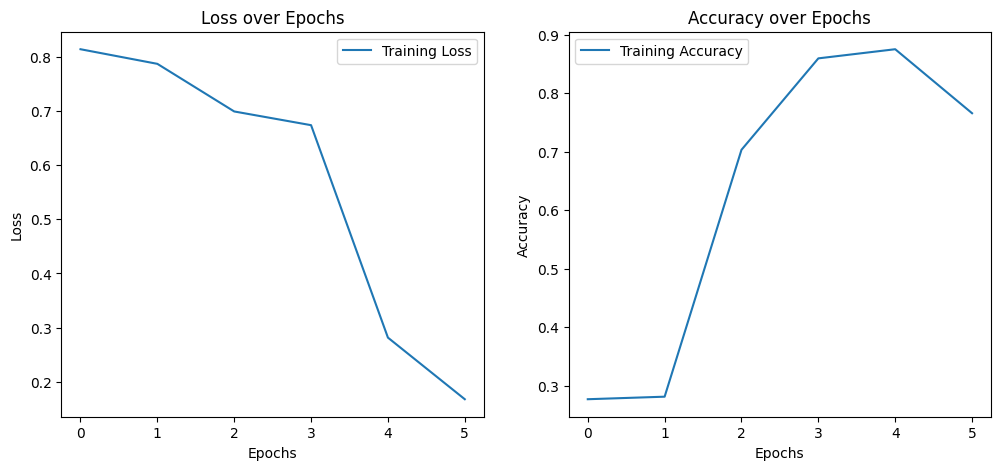

Correct cycle predictions: 35.5% (45.0%)
Correct complete predictions: 87.5% (95.0%)
Correct line predictions: 26.0% (42.0%)
Correct star predictions: 56.5% (74.0%)
Overall accuracy: 51.4% (64.0%)
-
New correct cycle predictions: 41.0%
New correct complete predictions: 94.0%
New correct line predictions: 25.0%
New correct star predictions: 51.0%
New overall accuracy: 52.8%
-
Selected k: {13: 0.005, 14: 0.2875, 15: 0.4325, 16: 0.275}
Types of selected graphs: {'isomorphic': 170, 'connected': 205, 'connected_pair': 16, 'random': 9}
Correct isomorphic: 154
Correct connected: 40
Correct connected pair: 16 (16)
Correct when k correct: 0.0


(35.5, 87.5, 26.0, 56.5, 51.375)

In [42]:
hyperparams = (32, 5, 0.2, 0.01, 64, 400)
# for hyperparams in hyperparameters:
newargs = NewArgs(*hyperparams)
model = GraphMatchingNetwork(newargs)
optimizer = Adam(model.parameters(), lr=newargs.lr, weight_decay=1e-5)
pairs, labels = create_graph_pairs(dataset, newargs.num_pairs)
train(model, optimizer, pairs, labels, newargs.batch_size)
acc_test(model, True, 0.84)

In [32]:
c = f"class_{str(0)}"
idx1 = random.sample(range(len(classes["class_0"])), 1)[0]
idx2 = random.sample(range(len(classes["class_1"])), 1)[0]
graph1, graph2 = classes["class_0"][idx1], classes["class_1"][idx2]

model.eval()

feats_1, edge_index_1 = graph1.x, graph1.edge_index
feats_2, edge_index_2 = graph2.x, graph2.edge_index
sizes_1 = torch.tensor([len(graph1.x)])
sizes_2 = torch.tensor([len(graph2.x)])
emb1, emb2, cluster1, cluster2, layer1, layer2 = model(
    feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
)


accs = []
cs = []
clustered_graphs = []

k = best_k(model)
# k = 8

best_acc1, best_acc2 = 0.0, 0.0
cluster1, cluster2 = None, None
layer1, layer2 = None, None

layers = []
sims = []

for i in range(len(model.layer_outputs)):
    (x_1, edge_index_1, x_2, edge_index_2) = model.layer_outputs[i]

    topk_pooling = TopKPooling(model.args.dim, ratio=k)

    x_pooled_1, edge_index_pooled_1, _, _, perm1, score1 = topk_pooling(
        x_1,
        edge_index_1,
    )
    x_pooled_2, edge_index_pooled_2, _, _, perm2, score2 = topk_pooling(
        x_2,
        edge_index_2,
    )

    acc1 = len(set(range(8)) & set(perm1.tolist()))
    acc2 = len(set(range(8)) & set(perm2.tolist()))

    layers.append(
        (
            (x_pooled_1, edge_index_pooled_1, score1),
            (x_pooled_2, edge_index_pooled_2, score2),
            i,
        )
    )

    clustered_graphs.append(
        (
            (
                Data(x=x_pooled_1, edge_index=edge_index_pooled_1),
                # abs(score1).sum().item(),
                calculate_weighted_confidence(score1),
            ),
            (
                Data(x=x_pooled_2, edge_index=edge_index_pooled_2),
                # abs(score2).sum().item(),
                calculate_weighted_confidence(score2),
            ),
        )
    )

    if acc1 > best_acc1:
        x = x_pooled_1
        cluster1 = Data(x=x_pooled_1, edge_index=edge_index_pooled_1)
        best_acc1 = acc1
        layer1 = i + 1
    if acc2 > best_acc2:
        cluster2 = Data(x=x_pooled_2, edge_index=edge_index_pooled_2)
        best_acc2 = acc2
        layer2 = i + 1

cs.append((layers, layer1, layer2))

accs.append(best_acc1)
accs.append(best_acc2)

connected_1 = []
connected_2 = []
connected_pairs = []
all_clusters = []
isomorphic = []

combined = []
connected = []

for i in range(len(clustered_graphs)):
    (g1, s1), (g2, s2) = clustered_graphs[i]
    if nx.is_connected(to_networkx(g1, to_undirected=True)):
        connected_1.append(g1)
    if nx.is_connected(to_networkx(g2, to_undirected=True)):
        connected_2.append(g2)

    if nx.is_connected(to_networkx(g1, to_undirected=True)) and nx.is_connected(
        to_networkx(g2, to_undirected=True)
    ):

        connected_pairs.append((g1, g2))

        mcs = max_common_subgraph(g1, g2)
        combined_data = combine_graphs(g1, g2, mcs, ratio=0.5)
        combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = topk_pooling(
            combined_data.x, combined_data.edge_index
        )

        combined_clustered = Data(
            x=combined_clustered_x, edge_index=combined_clustered_edge_index
        )

        if nx.is_isomorphic(
            to_networkx(g1, to_undirected=True), to_networkx(g2, to_undirected=True)
        ):
            isomorphic.append(combined_clustered)
        # else:
        #     combined.append(combined_clustered)

    all_clusters.append(g1)
    all_clusters.append(g2)

connected = connected_1 + connected_2

for g1 in connected_1:
    for g2 in connected_2:
        if nx.is_isomorphic(
            to_networkx(g1, to_undirected=True), to_networkx(g2, to_undirected=True)
        ):
            mcs = max_common_subgraph(g1, g2)
            combined_data = combine_graphs(g1, g2, mcs, ratio=0.5)
            combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = (
                topk_pooling(combined_data.x, combined_data.edge_index)
            )

            combined_clustered = Data(
                x=combined_clustered_x, edge_index=combined_clustered_edge_index
            )
            if (
                nx.is_connected(to_networkx(combined_clustered, to_undirected=True))
            ) and (
                nx.is_isomorphic(
                    to_networkx(combined_clustered, to_undirected=True),
                    to_networkx(g1, to_undirected=True),
                )
                or nx.is_isomorphic(
                    to_networkx(combined_clustered, to_undirected=True),
                    to_networkx(g2, to_undirected=True),
                )
            ):
                combined.append(combined_clustered)

if isomorphic != []:
    cluster = find_most_common_graph(isomorphic, 2, model)
    t = "isomorphic"
elif combined != []:
    cluster = find_most_common_graph(combined, 2, model)
    t = "connected_pair"
elif connected != []:
    cluster = connected[0]
    t = "connected"
else:
    cluster = random.choice(all_clusters)
    t = "random"


print(len(isomorphic))
print(len(combined))
print(len(connected_pairs))
print(len(connected))

0
0
2
6


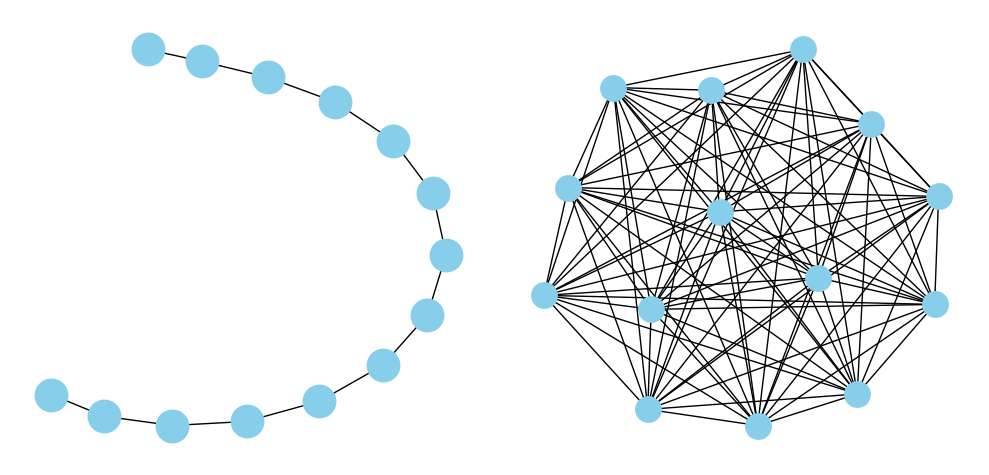

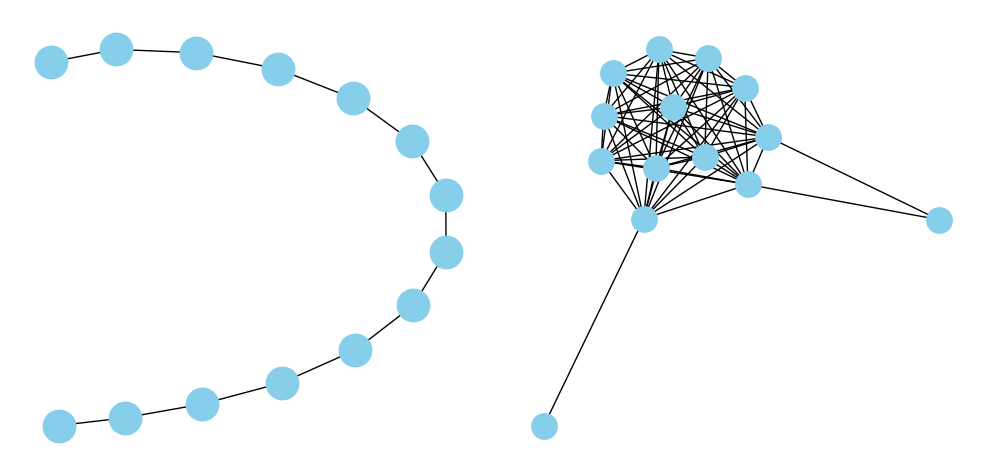

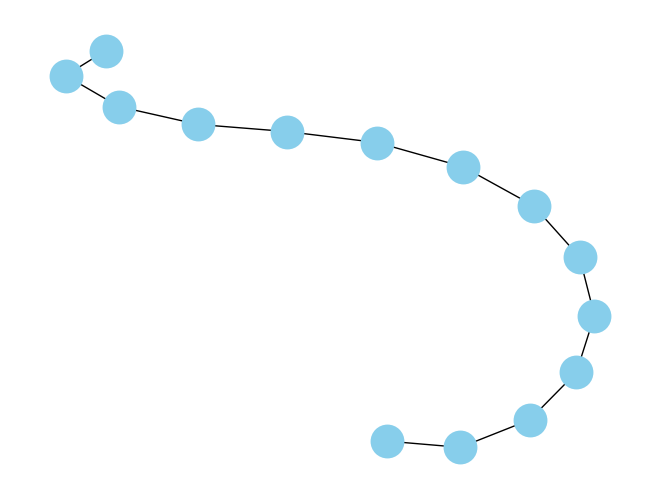

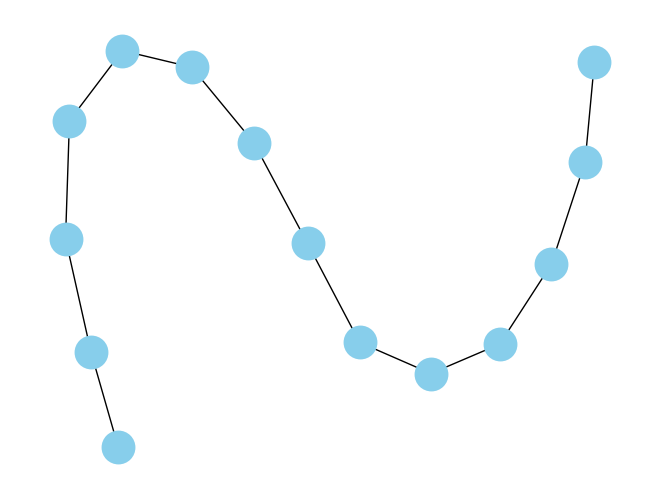

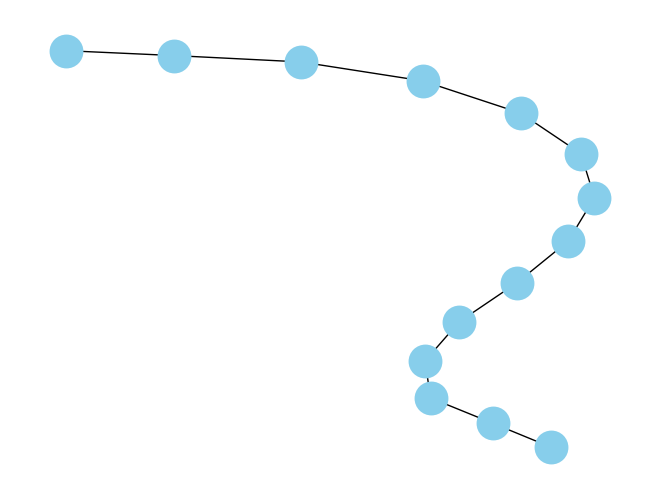

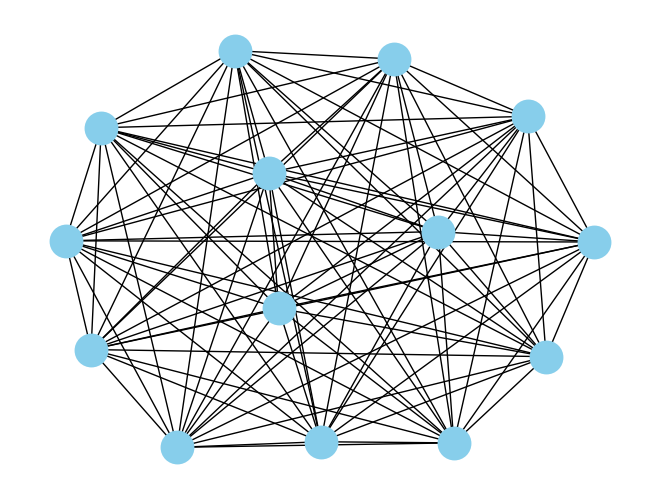

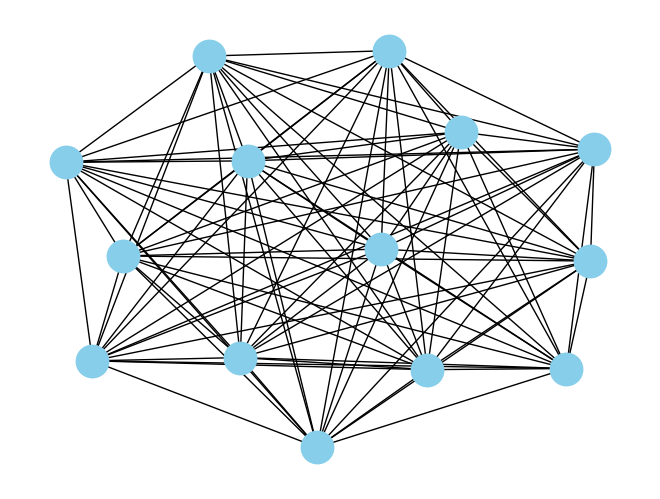

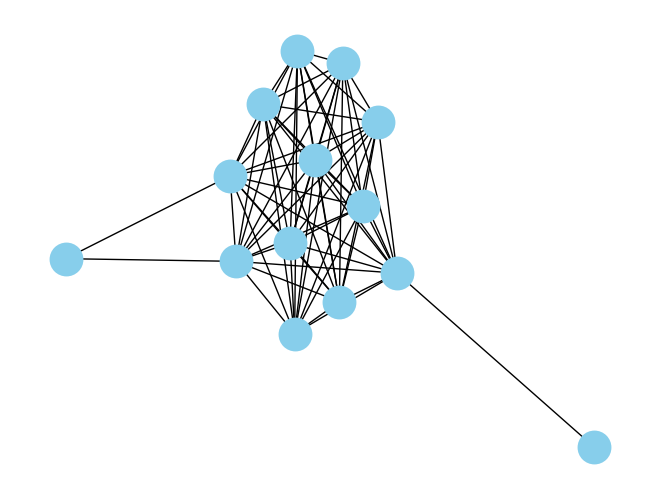

In [33]:
for g1, g2 in connected_pairs:
    plot_graph_pair(g1, g2)

for g in connected:
    plot_graph(g)

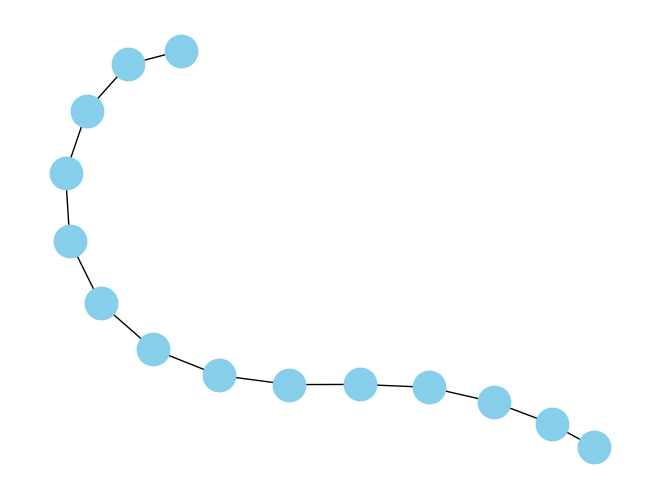

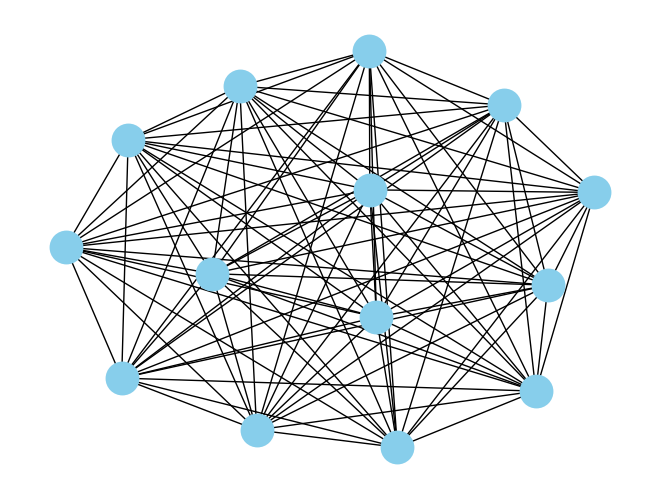

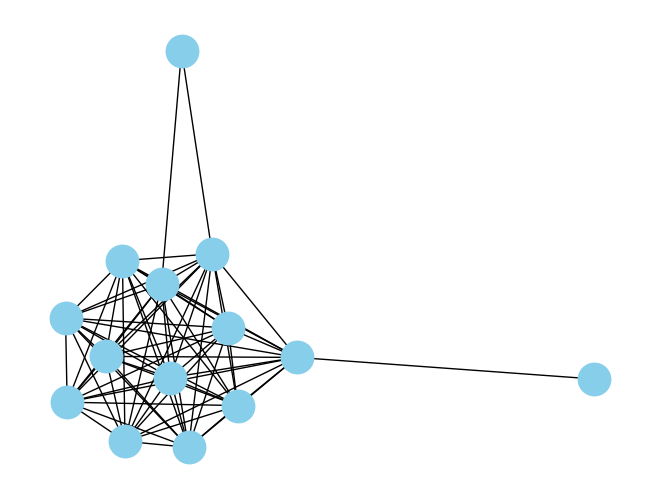

----------------------


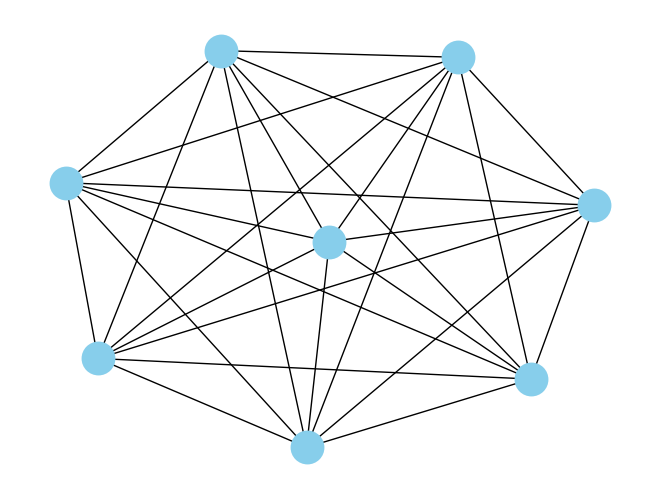

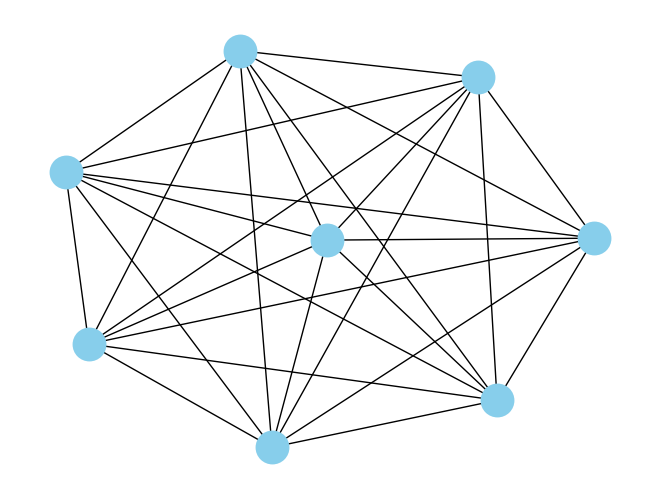

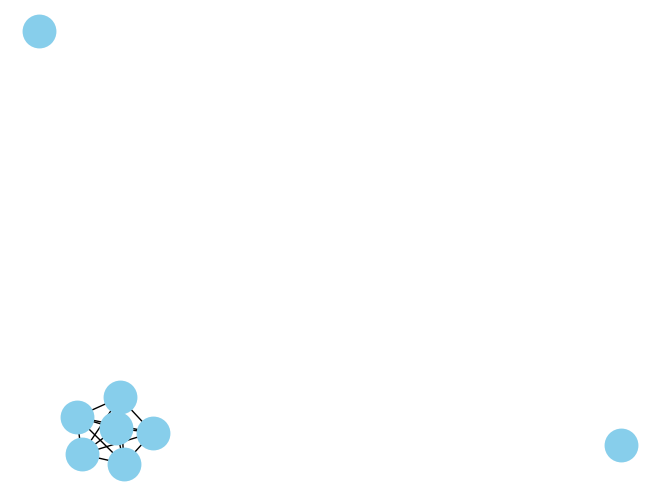

----------------------


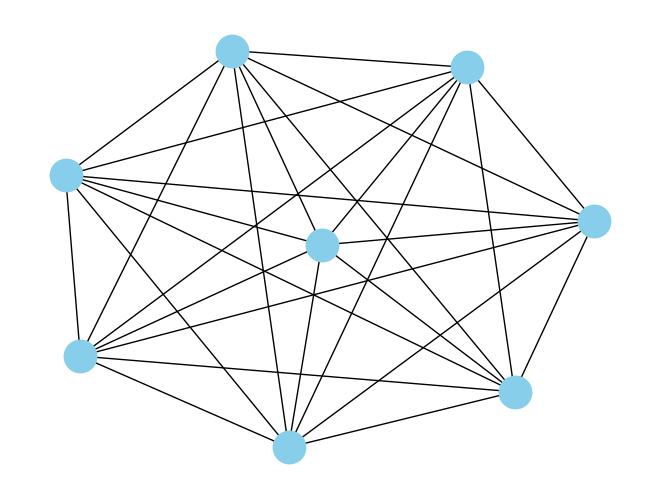

In [34]:
def graph_hash(graph):
    G = to_networkx(graph, to_undirected=True)
    return tuple(sorted([d for n, d in G.degree()]))


hash_counts = defaultdict(int)
graph_by_hash = {}

for graph in connected:
    plot_graph
    hash_val = graph_hash(graph)
    hash_counts[hash_val] += 1
    if hash_val not in graph_by_hash:
        graph_by_hash[hash_val] = graph
    # plot_graph(graph, str(hash_val))

most_common_hashes = sorted(hash_counts, key=hash_counts.get, reverse=True)
most_common_graphs = [graph_by_hash[hash_key] for hash_key in most_common_hashes]

for g in most_common_graphs:
    plot_graph(g)

# print(hash_counts)

print("----------------------")

combined_clusters = []

for i in range(len(most_common_graphs)):
    for j in range(0, i):
        g1 = most_common_graphs[i]
        g2 = most_common_graphs[j]

        G1 = to_networkx(g1, to_undirected=True)
        G2 = to_networkx(g2, to_undirected=True)

        mcs = max_common_subgraph(g1, g2)

        combined_graph = combine_graphs(g1, g2, mcs)

        topk_pooling = TopKPooling(model.args.dim, ratio=8)
        combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = topk_pooling(
            combined_graph.x, combined_graph.edge_index
        )
        combined_clustered = Data(
            x=combined_clustered_x, edge_index=combined_clustered_edge_index
        )

        plot_graph(combined_clustered)

        combined_clusters.append(combined_clustered)

print("----------------------")


combined_hash_counts = defaultdict(int)
combined_graph_by_hash = {}

for graph in combined_clusters:
    hash_val = graph_hash(graph)
    combined_hash_counts[hash_val] += 1
    if hash_val not in combined_graph_by_hash:
        combined_graph_by_hash[hash_val] = graph

most_common_combined_hash = max(combined_hash_counts, key=combined_hash_counts.get)
most_common_combined_graph = combined_graph_by_hash[most_common_combined_hash]

plot_graph(most_common_combined_graph)